In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

In [30]:
plt.style.use('notebook')

In [3]:
tp = Table(fits.getdata('../data/pal5_ls_lite_grz.fits'))

In [4]:
tflag = Table.read('../data/cmd_masks_orig.fits')

In [5]:
t = Table(fits.getdata('../data/legacysurvey-bricks-dr7.fits.gz'))

In [8]:
print(np.sum(tflag['gr_mask']), np.sum(tflag['gr_mask'] & tflag['grz_mask']))

156752 130348


In [9]:
tout = tp[tflag['gr_mask']]

In [10]:
tout['grz_mask'] = tflag['grz_mask'][tflag['gr_mask']]

In [19]:
cbrick = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, frame='icrs')

In [20]:
cmem = coord.SkyCoord(ra=tout['ra']*u.deg, dec=tout['dec']*u.deg, frame='icrs')

In [21]:
idx, d2d, d3d = cmem.match_to_catalog_sky(cbrick)

In [23]:
print(t.colnames)

['brickname', 'ra', 'dec', 'nexp_g', 'nexp_r', 'nexp_z', 'nexphist_g', 'nexphist_r', 'nexphist_z', 'nobjs', 'npsf', 'nsimp', 'nrex', 'nexp', 'ndev', 'ncomp', 'psfsize_g', 'psfsize_r', 'psfsize_z', 'psfdepth_g', 'psfdepth_r', 'psfdepth_z', 'galdepth_g', 'galdepth_r', 'galdepth_z', 'ebv', 'trans_g', 'trans_r', 'trans_z', 'ext_g', 'ext_r', 'ext_z', 'wise_nobs', 'trans_wise', 'ext_w1', 'ext_w2', 'ext_w3', 'ext_w4']


In [24]:
tout['glim'] = t['psfdepth_g'][idx]
tout['rlim'] = t['psfdepth_r'][idx]
tout['zlim'] = t['psfdepth_z'][idx]

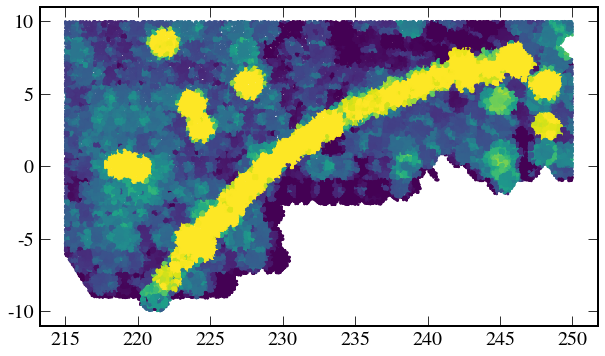

In [28]:
plt.figure(figsize=(10,6))

plt.scatter(tout['ra'], tout['dec'], c=tout['zlim'], vmin=23, vmax=24, s=3, )

plt.gca().set_aspect('equal')

In [279]:
c = cmem.transform_to(gc.Pal5)

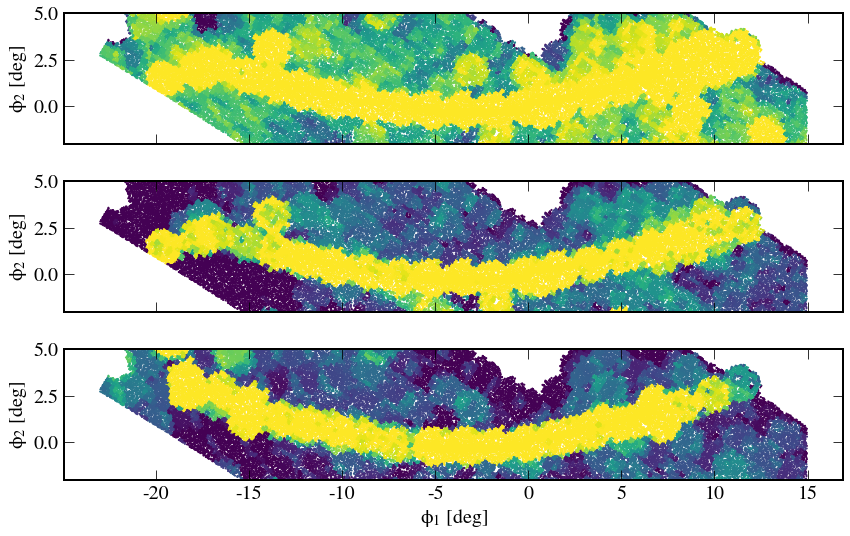

In [38]:
fig, ax = plt.subplots(3,1,figsize=(12,8), sharex=True, sharey=True)

llim = [24,24,23]
ulim = [25,25,24]

for e, band in enumerate(['g', 'r', 'z']):
    plt.sca(ax[e])
    plt.scatter(c.phi1, c.phi2, c=tout['{:s}lim'.format(band)], vmin=llim[e], vmax=ulim[e], s=1)

    plt.ylim(-2,5)
    plt.gca().set_aspect('equal')
    plt.ylabel('$\phi_2$ [deg]')

plt.xlabel('$\phi_1$ [deg]')
plt.tight_layout()

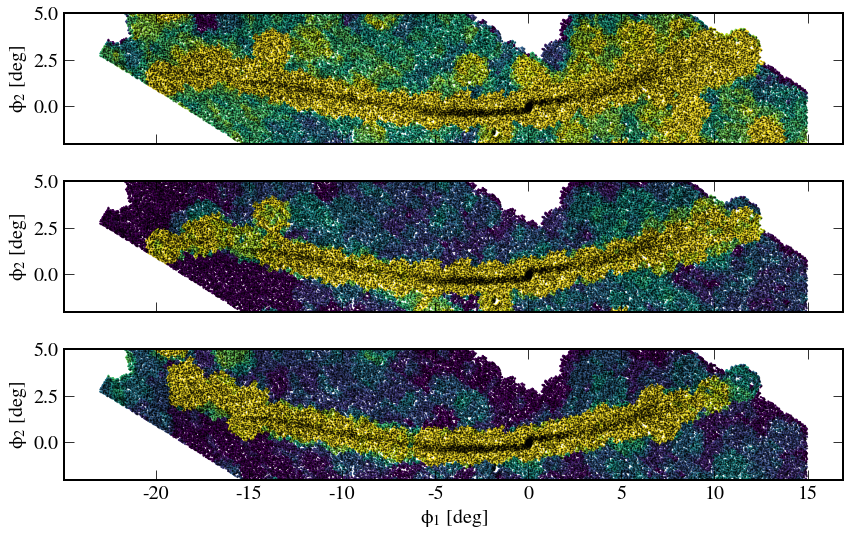

In [42]:
fig, ax = plt.subplots(3,1,figsize=(12,8), sharex=True, sharey=True)

llim = [24,24,23]
ulim = [25,25,24]

for e, band in enumerate(['g', 'r', 'z']):
    plt.sca(ax[e])
    plt.scatter(c.phi1, c.phi2, c=tout['{:s}lim'.format(band)], vmin=llim[e], vmax=ulim[e], s=1)
    plt.plot(c.phi1[tout['grz_mask']], c.phi2[tout['grz_mask']], 'k.', ms=1, alpha=0.4)

    plt.ylim(-2,5)
    plt.gca().set_aspect('equal')
    plt.ylabel('$\phi_2$ [deg]')

plt.xlabel('$\phi_1$ [deg]')
plt.tight_layout()

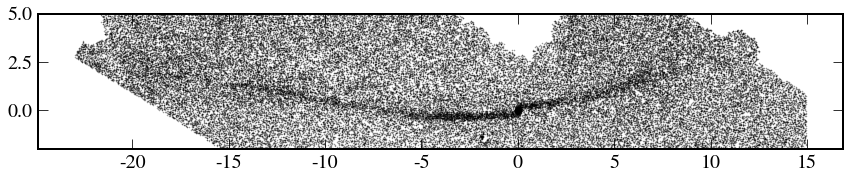

In [41]:
plt.figure(figsize=(12,8))
plt.plot(c.phi1[tout['grz_mask']], c.phi2[tout['grz_mask']], 'k.', ms=1, alpha=0.4)

plt.ylim(-2,5)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [43]:
from scipy.spatial import ConvexHull

In [123]:
points = np.array([c.phi1, c.phi2]).T

In [428]:
mask_zlim = 23.7
mask_hull = (tout['zlim']>mask_zlim) & (c.phi1>-17*u.deg) & (c.phi1<8*u.deg) & (c.phi2<3*u.deg) & (c.phi2>-2*u.deg)

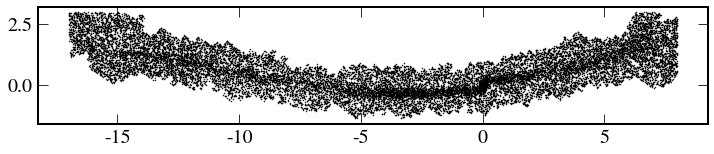

In [429]:
plt.figure(figsize=(12,8))
plt.plot(points[mask_hull][:,0], points[mask_hull][:,1], 'k.', ms=1)

plt.gca().set_aspect('equal')

In [430]:
hull = ConvexHull(points[mask_hull])

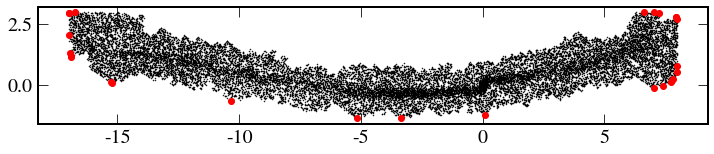

In [431]:
plt.figure(figsize=(12,8))
plt.plot(points[mask_hull][:,0], points[mask_hull][:,1], 'k.', ms=1)
plt.plot(points[mask_hull][hull.vertices,0], points[mask_hull][hull.vertices,1], 'ro')
plt.gca().set_aspect('equal')


In [432]:
path_hull = mpl.path.Path(points[mask_hull][hull.vertices])
convex_mask = path_hull.contains_points(points)

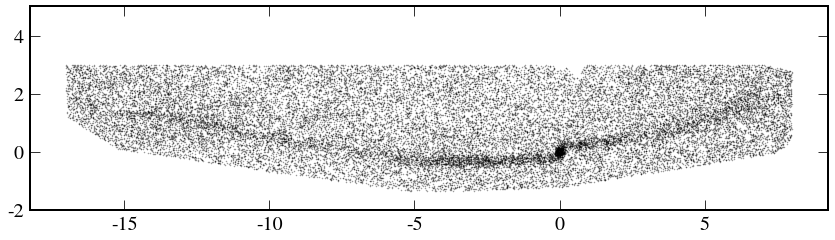

In [433]:
plt.figure(figsize=(12,8))
plt.plot(c.phi1[tout['grz_mask'] & convex_mask], c.phi2[tout['grz_mask'] & convex_mask], 'k.', ms=1, alpha=0.4)

plt.ylim(-2,5)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [434]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import shapely.geometry as geometry


In [435]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

#     coords = np.array([point[0] for point in points])
    coords = points

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = np.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = np.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = np.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = np.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [436]:
concave_hull, edge_points = alpha_shape(points[mask_hull], alpha=0.1)

In [437]:
path_concavehull = mpl.path.Path(np.array(concave_hull.exterior.xy).T)
concave_mask = path_concavehull.contains_points(points)

In [444]:
np.savez('../data/concave_hull_z{:.1f}'.format(mask_zlim), pts=np.array(concave_hull.exterior.xy).T)

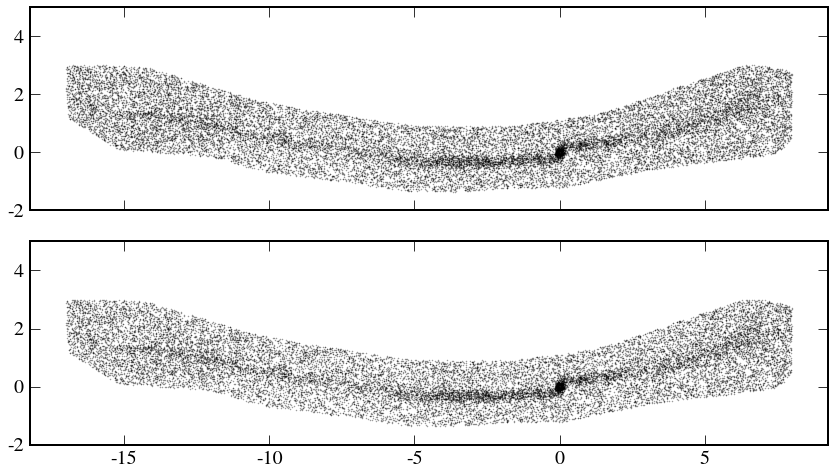

In [445]:
fig, ax = plt.subplots(2,1,figsize=(12,7), sharex=True, sharey=True)
plt.sca(ax[0])
plt.plot(c.phi1[concave_mask], c.phi2[concave_mask], 'k.', ms=1, alpha=0.4)

plt.ylim(-2,5)
plt.gca().set_aspect('equal')

plt.sca(ax[1])
plt.plot(c.phi1[tout['grz_mask'] & concave_mask], c.phi2[tout['grz_mask'] & concave_mask], 'k.', ms=1, alpha=0.4)

plt.ylim(-2,5)
plt.gca().set_aspect('equal')

plt.tight_layout()

In [446]:
pts = np.load('../data/concave_hull_z{:.1f}.npz'.format(mask_zlim))['pts']

In [447]:
pts

array([[  0.08514547,  -1.2263048 ],
       [ -1.69620364,  -1.21910366],
       [ -1.7507161 ,  -1.22230053],
       [ -3.33251283,  -1.36273588],
       [ -3.3391255 ,  -1.36215167],
       [ -5.16546482,  -1.36033212],
       [ -7.23547703,  -1.05195199],
       [ -7.35888211,  -1.03606308],
       [-10.32145823,  -0.64650922],
       [-10.42643766,  -0.60837947],
       [-11.89113997,  -0.16288449],
       [-15.20739214,   0.09299216],
       [-15.26517689,   0.12655957],
       [-15.41373354,   0.22492697],
       [-15.82388633,   0.48520169],
       [-16.02567022,   0.62586169],
       [-16.91481476,   1.1693354 ],
       [-16.92145495,   1.1870674 ],
       [-16.9563431 ,   1.33611213],
       [-16.95739355,   1.37372755],
       [-16.99705107,   2.0782649 ],
       [-16.99239685,   2.6691663 ],
       [-16.99923258,   2.94670022],
       [-16.98758293,   2.97070706],
       [-16.75368762,   2.99843948],
       [-16.61675866,   2.99605741],
       [-16.36941979,   2.99524156],
 

## Find track

In [415]:
# setup bins
dx = 0.75
# dx = 1
phi1_be = np.arange(-15.5,7+dx,dx)*u.deg
phi1_bc = 0.5*(phi1_be[1:] + phi1_be[:-1])

In [416]:
Nb = np.size(phi1_bc)
phi2_med = np.zeros(Nb)*u.deg
print(Nb)

for i in range(Nb):
    ind = (c.phi1>phi1_be[i]) & (c.phi1<=phi1_be[i+1]) & tout['grz_mask'] & concave_mask
    phi2_med[i] = np.median(c.phi2[ind])

30


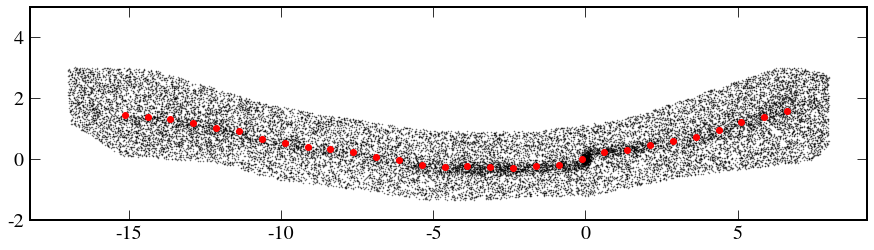

In [417]:
plt.figure(figsize=(15,8))
plt.plot(c.phi1[tout['grz_mask'] & concave_mask], c.phi2[tout['grz_mask'] & concave_mask], 'k.', ms=1, alpha=0.6)
plt.plot(phi1_bc, phi2_med, 'ro')

plt.ylim(-2,5)
plt.gca().set_aspect('equal')


In [418]:
# refine
dy = 2*u.deg

for i in range(Nb):
    ind = ((c.phi1>phi1_be[i]) & (c.phi1<=phi1_be[i+1]) & tout['grz_mask'] & concave_mask 
           & (np.abs(c.phi2-phi2_med[i])<dy))
    phi2_med[i] = np.median(c.phi2[ind])

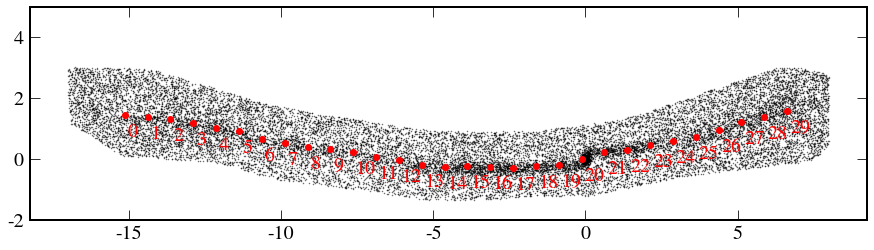

In [419]:
plt.figure(figsize=(15,8))
plt.plot(c.phi1[tout['grz_mask'] & concave_mask], c.phi2[tout['grz_mask'] & concave_mask], 'k.', ms=1, alpha=0.6)
plt.plot(phi1_bc, phi2_med, 'ro')
for i in range(Nb):
    plt.text(phi1_bc[i].value+0.1, phi2_med[i].value-0.7, '{:d}'.format(i), color='r')

plt.ylim(-2,5)
plt.gca().set_aspect('equal')


In [420]:
from scipy.interpolate import UnivariateSpline
from scipy import interpolate

In [421]:
ts, cs, ks = interpolate.splrep(phi1_bc.value, phi2_med.value, s=0, k=2)
# print('''\
# t: {}
# c: {}
# k: {}
# '''.format(t, c, k))
N = 100
x = phi1_bc
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(ts, cs, ks, extrapolate=False)
spline_der = spline.derivative()

In [422]:
spl = UnivariateSpline(phi1_bc, phi2_med, k=4)
spl_der = spl.derivative()

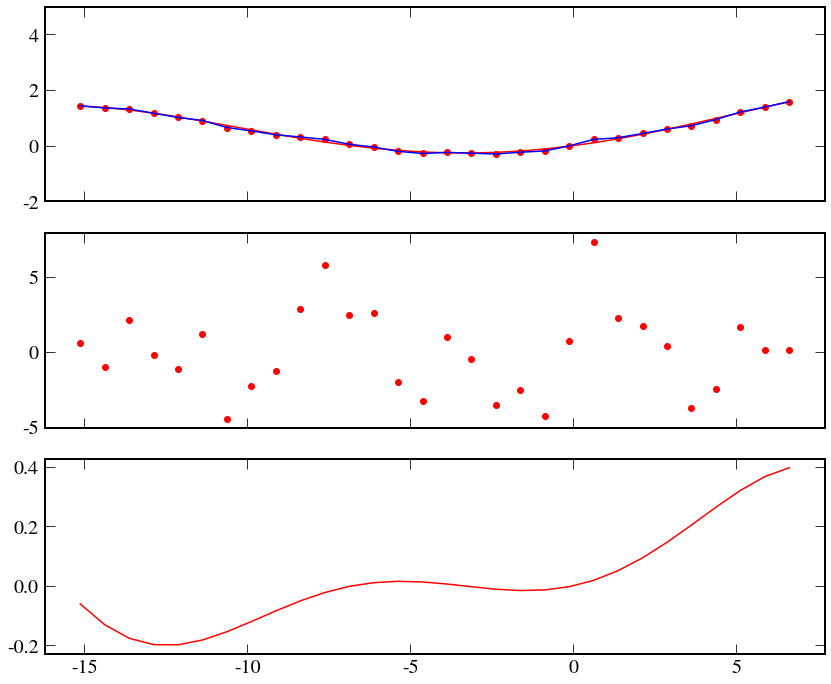

In [423]:
fig, ax = plt.subplots(3,1,figsize=(12,10), sharex=True)
plt.sca(ax[0])
plt.plot(phi1_bc, phi2_med, 'ro')
plt.plot(phi1_bc, spl(phi1_bc), 'r-')
plt.plot(phi1_bc, spline(phi1_bc), 'b-')

plt.ylim(-2,5)

plt.sca(ax[1])
plt.plot(phi1_bc, (phi2_med - spl(phi1_bc)*u.deg).to(u.arcmin), 'ro')
# plt.plot(phi1_bc, (phi2_med - spline(phi1_bc)*u.deg).to(u.arcmin), 'bo')


plt.sca(ax[2])
plt.plot(phi1_bc, spl(phi1_bc)*spl_der(phi1_bc), 'r-')
# plt.plot(phi1_bc, spline_der(phi1_bc), 'b-')

plt.tight_layout()


## $\phi_2$ profiles

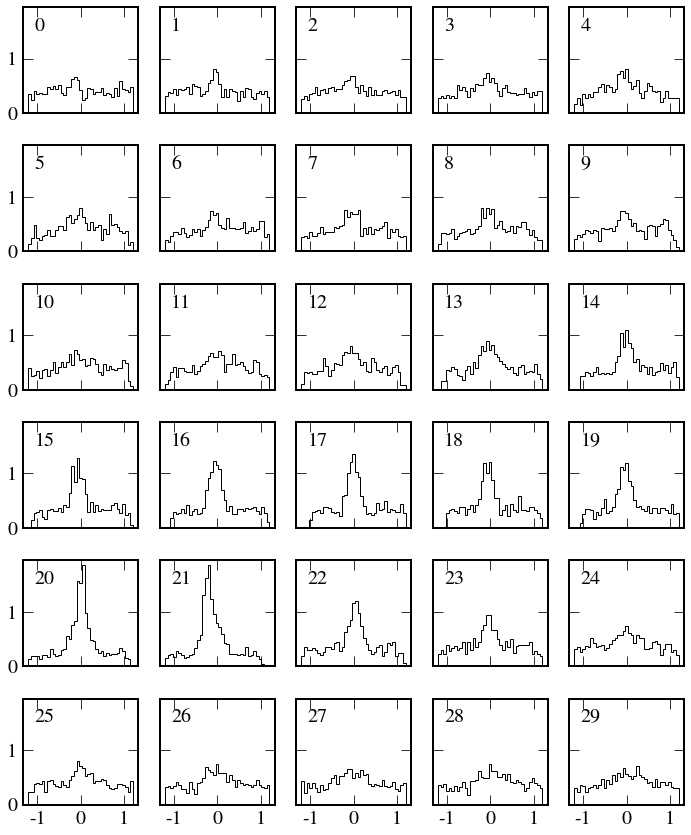

In [427]:
nrow = 6
ncol = 5
dd = 2
bphi2 = np.linspace(-1.2,1.2,40)

fig, ax = plt.subplots(nrow, ncol, figsize=(dd*ncol, dd*nrow), sharey=True, sharex=True)

for i in range(nrow):
    for j in range(ncol):
        plt.sca(ax[i][j])
        itot = i*ncol + j
        if itot<Nb:
            ind = tout['grz_mask'] & concave_mask & (np.abs(c.phi1-phi1_bc[itot])<=dx*u.deg)
            plt.hist(c.phi2[ind].value - phi2_med[itot].value, bins=bphi2, histtype='step', color='k', density=True)
            plt.text(0.1,0.9, '{:d}'.format(itot), transform=plt.gca().transAxes, va='top')
        else:
            plt.axis('off')

plt.tight_layout()